### 结合归一化和正则化来优化网络模型结构，观察对比loss结果


In [1]:
import torch
import torch.nn as nn

from sklearn.datasets import fetch_olivetti_faces


In [2]:
# 加载数据集  ​​40 个不同个体​​，每人 ​​10 张人脸图像​​，共 ​​400 张图像​​，以灰度图形式存储
olivetti_faces = fetch_olivetti_faces(data_home='./face_data', shuffle=True)

In [3]:
images = torch.tensor(olivetti_faces.data) # 400*4096
targets = torch.tensor(olivetti_faces.target) # 400
dataset = [(img,lbl) for img,lbl in zip(images, targets)]  

In [4]:
images,targets

(tensor([[0.6694, 0.6364, 0.6488,  ..., 0.0868, 0.0826, 0.0744],
         [0.7686, 0.7562, 0.7438,  ..., 0.4835, 0.6281, 0.6529],
         [0.3719, 0.3471, 0.3678,  ..., 0.7066, 0.6818, 0.5496],
         ...,
         [0.5579, 0.6033, 0.6570,  ..., 0.1777, 0.2066, 0.1942],
         [0.5207, 0.5207, 0.5331,  ..., 0.4669, 0.4380, 0.4380],
         [0.3967, 0.3678, 0.3430,  ..., 0.3719, 0.2686, 0.2975]]),
 tensor([13, 30, 34, 19, 24,  6, 15, 26, 14, 21,  3, 13, 11, 34,  1,  5, 29, 14,
         20, 19, 17, 26, 12, 34, 17, 31,  7,  1, 28, 10, 17, 30, 33, 22,  6,  7,
          9, 17, 17, 39, 10, 32,  0,  0, 29,  5, 37, 25, 15, 23, 24, 14, 29, 17,
         28, 31,  5,  1,  2,  4,  7, 27,  0, 35, 19, 37, 14,  0, 15, 31,  0, 26,
          6,  2, 10,  1, 36, 30, 36, 32, 33,  6,  5, 10, 30, 22, 12, 37, 39, 32,
         38, 25,  5,  0, 19, 14, 13, 39, 26, 36, 25,  6, 31, 15, 28, 34,  8, 34,
         15, 29,  9,  8, 29,  2, 36, 21, 25,  4, 23, 34,  9, 22, 23, 23, 37, 14,
          2, 25, 35, 16, 15

In [5]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True) # 创建数据加载器
for data in dataloader:
    print(data[0].shape)  # torch.Size([10, 4096])
    print(data[1].shape)  # torch.Size([10])
    break  # 只打印第一个批次的数据
dataloader

torch.Size([10, 4096])
torch.Size([10])


In [6]:
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
# 多层神经网络模型
model = nn.Sequential(
    nn.Linear(4096, 8192),
    nn.BatchNorm1d(8192),
    nn.ReLU(),
    nn.Dropout(),

    nn.Linear(8192, 16384),
    nn.BatchNorm1d(16384),
    nn.ReLU(),
    nn.Dropout(),

    nn.Linear(16384, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(),
    
    nn.Linear(1024, 40)
).to(device)  # 将模型移动到 GPU 上,如果可用的话

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
loss_hist = []
for i in range(10):
    for img,lbl in dataloader:
        img,lbl = img.to(device), lbl.to(device)  # 数据和模型在同一个设备端
        lbl = lbl.long()  # 将标签转换为 Long 类型 <<< 核心修复点
        result = model(img)
        loss = criterion(result, lbl)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist.append(loss.item())
        print(f'epoch:{i+1} loss:{loss.item():.4f}')

epoch:1 loss:4.0357
epoch:1 loss:3.6210
epoch:1 loss:4.2234
epoch:1 loss:3.9229
epoch:1 loss:3.8777
epoch:1 loss:3.6171
epoch:1 loss:4.4291
epoch:1 loss:3.1774
epoch:1 loss:3.7047
epoch:1 loss:3.7130
epoch:1 loss:3.7782
epoch:1 loss:3.5640
epoch:1 loss:3.7429
epoch:1 loss:4.1702
epoch:1 loss:3.0478
epoch:1 loss:3.3086
epoch:1 loss:3.5006
epoch:1 loss:2.9264
epoch:1 loss:4.1404
epoch:1 loss:3.1098
epoch:1 loss:3.4452
epoch:1 loss:3.3174
epoch:1 loss:3.1305
epoch:1 loss:2.5958
epoch:1 loss:3.7953
epoch:1 loss:3.3161
epoch:1 loss:3.2508
epoch:1 loss:3.7497
epoch:1 loss:3.4006
epoch:1 loss:2.5133
epoch:1 loss:2.8436
epoch:1 loss:3.7706
epoch:1 loss:2.9048
epoch:1 loss:2.4827
epoch:1 loss:3.0489
epoch:1 loss:2.6094
epoch:1 loss:3.4941
epoch:1 loss:3.4707
epoch:1 loss:2.6920
epoch:1 loss:3.3430
epoch:2 loss:2.1888
epoch:2 loss:2.4600
epoch:2 loss:2.5246
epoch:2 loss:2.1066
epoch:2 loss:1.7803
epoch:2 loss:2.3010
epoch:2 loss:2.8708
epoch:2 loss:2.8316
epoch:2 loss:2.1359
epoch:2 loss:2.3027


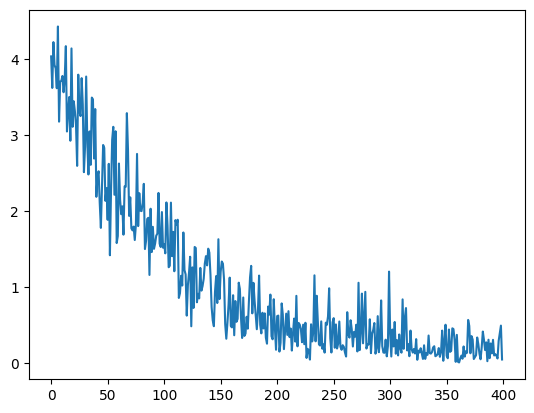

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_hist)), loss_hist)
plt.show()